In [1]:
using Gmsh:gmsh
using Gridap
using GridapGmsh
using Gridap.TensorValues
using PyPlot
using LinearAlgebra

In [2]:
const lsp = 0.0075

0.0075

In [3]:
const L = 1
const H = 1
const CP = H/2
const CL = 0.5*L 
const CH = H/1000
const hfc = lsp/50
const hf = lsp/10
const h = 50*hf 
const FMR = 5*lsp
 
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.geo.addPoint(0.0, 0.0, 0.0, h, 1)  
gmsh.model.geo.addPoint(L, 0.0, 0.0, h, 2) 
gmsh.model.geo.addPoint(L, H, 0.0, h, 3) 
gmsh.model.geo.addPoint(0.0, H, 0.0, h, 4)
gmsh.model.geo.addPoint(0.0, CP + CH, 0.0, h, 5)
gmsh.model.geo.addPoint(CL, CP + CH, 0.0, hfc, 6)
gmsh.model.geo.addPoint(CL, CP - CH, 0.0, hfc, 7)
gmsh.model.geo.addPoint(0.0, CP - CH, 0.0, h, 8)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 7, 6)
gmsh.model.geo.addLine(7, 8, 7)
gmsh.model.geo.addLine(8, 1, 8)
gmsh.model.geo.addCurveLoop([1,2,3,4,5,6,7,8],1) 
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.addPhysicalGroup(2, [1],1)
gmsh.model.addPhysicalGroup(1, [1],1)
gmsh.model.addPhysicalGroup(1, [3],2)
gmsh.model.setPhysicalName(2, 1, "Domain")
gmsh.model.setPhysicalName(1, 1, "DirichletBot")
gmsh.model.setPhysicalName(1, 2, "DirichletTop")


gmsh.model.mesh.field.add("Box", 11)
gmsh.model.mesh.field.setNumber(11, "VIn", hf)
gmsh.model.mesh.field.setNumber(11, "VOut", h)
gmsh.model.mesh.field.setNumber(11, "XMin", 0.95*CL)
gmsh.model.mesh.field.setNumber(11, "XMax", L)
gmsh.model.mesh.field.setNumber(11, "YMin", CP-FMR)
gmsh.model.mesh.field.setNumber(11, "YMax", CP+FMR)
gmsh.model.mesh.field.setAsBackgroundMesh(11)

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("SquarePlateWithEdgeNotch.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.00988988s, CPU 0.009896s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 2.66578s, CPU 2.64179s)
Info    : 71135 nodes 142276 elements
Info    : Writing 'SquarePlateWithEdgeNotch.msh'...
Info    : Done writing 'SquarePlateWithEdgeNotch.msh'


In [4]:
model = GmshDiscreteModel("SquarePlateWithEdgeNotch.msh")
writevtk(model,"SquarePlateWithEdgeNotch")

Info    : Reading 'SquarePlateWithEdgeNotch.msh'...
Info    : 17 entities
Info    : 71135 nodes
Info    : 141929 elements
Info    : Done reading 'SquarePlateWithEdgeNotch.msh'


3-element Vector{Vector{String}}:
 ["SquarePlateWithEdgeNotch_0.vtu"]
 ["SquarePlateWithEdgeNotch_1.vtu"]
 ["SquarePlateWithEdgeNotch_2.vtu"]

In [5]:
using Gridap.Geometry
labels = get_face_labeling(model)
dimension = 2
mat_tags = get_face_tag(labels,dimension)

141875-element Vector{Int8}:
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [6]:
const E = 210e3
const ν = 0.3
G = E/(2*(1+ν))
l = 0.05
N = 0.5
Gc = 2.7

const η = 1e-15

1.0e-15

In [7]:
@show μ = 53846.1538461538
@show κ = 53846.1538461538
@show λ = 121153.84615384605
@show γ = 807.692307692307

μ = 53846.1538461538 = 53846.1538461538
κ = 53846.1538461538 = 53846.1538461538
λ = 121153.84615384605 = 121153.84615384605
γ = 807.692307692307 = 807.692307692307


807.692307692307

In [8]:
function Eigen(ε)
    εArray = get_array(ε)
    Λ, P = eigen(εArray)
    ε1 = Λ[1]
    ε2 = Λ[2]
    if ε1 >= 0 &&  ε2 >= 0
        Λpos = [ε1 0; 0 ε2]
        Λneg = [0 0; 0 0]
    elseif ε1 >= 0 &&  ε2 < 0
        Λpos = [ε1 0; 0 0]
        Λneg = [0 0; 0 ε2]
    elseif ε1 < 0 &&  ε2 >= 0
        Λpos = [0 0; 0 ε2]
        Λneg = [ε1 0; 0 0]
    elseif ε1 < 0 &&  ε2 < 0
        Λpos = [0 0; 0 0]
        Λneg = [ε1 0; 0 ε2]
    end 
    εPos = TensorValue(P*Λpos*P')
    εNeg = TensorValue(P*Λneg*P')
    if tr(ε) >= 0
        ψPos = 0.5*(λ*(tr(ε))^2 + (2*μ+κ)*(εPos ⊙ εPos))
        ψNeg = 0.5*(2*μ+κ)*(εNeg ⊙ εNeg)
    else
        ψPos = 0.5*((2*μ+κ)*(εPos ⊙ εPos))
        ψNeg = 0.5*(λ*(tr(ε))^2 +(2*μ+κ)*(εNeg ⊙ εNeg))
    end
    if ψPos >= ψNeg
        case = 1
    else
        case = 2
    end
    return case, ψPos, ψNeg 
end

Eigen (generic function with 1 method)

In [9]:
function σ_Bmod(ε, ε_in, s_in)
    case, ψP, ψN = Eigen(ε_in)
    if case == 1
        σM = (s_in^2 + η)*(λ*tr(ε)*one(ε) + (2*μ + κ)*(ε))
    else
        σM = (λ*tr(ε)*one(ε) + (2*μ + κ)*(ε))
    end
    return σM
end

σ_Bmod (generic function with 1 method)

In [10]:
E_Matrx = TensorValue(0,1,-1,0)

TensorValue{2, 2, Int64, 4}(0, 1, -1, 0)

In [11]:
function ε_Skw(∇,θ)
    ∇ᵀ = transpose(∇)
    w = (0.5*(∇ᵀ - ∇)) - (E_Matrx*θ)
    return w
end

ε_Skw (generic function with 1 method)

In [12]:
function σ_Cmod(ϵ_skew, s_in)
    σM = (s_in^2 + η)*(κ*ϵ_skew)
    return σM
end

σ_Cmod (generic function with 1 method)

In [13]:
function M_mod(∇, s_in)
    M = (s_in^2 + η)*(γ*∇)
    return M
end

M_mod (generic function with 1 method)

In [14]:
function ψPos(ε_in,∇_uh,θ, ∇_th)
    ∇_uhᵀ = transpose(∇_uh)
    ϵ_skew = 0.5*(∇_uhᵀ - ∇_uh) - E_Matrx*θ
    case, ψP, ψN = Eigen(ε_in)
    ψPos = ψP + 0.5*(κ*(ϵ_skew ⊙ ϵ_skew)) + 0.5*γ*(∇_th ⋅ ∇_th)
    return ψPos 
end

ψPos (generic function with 1 method)

In [15]:
function new_EnergyState(ψPlusPrev_in,ψhPos_in)
    ψPlus_in = ψhPos_in
    if ψPlus_in >= ψPlusPrev_in
        ψPlus_out = ψPlus_in
    else
        ψPlus_out = ψPlusPrev_in
    end
    true,ψPlus_out
end

new_EnergyState (generic function with 1 method)

In [16]:
function project(q,model,dΩ,order)
  reffe = ReferenceFE(lagrangian,Float64,order)
  V = FESpace(model,reffe,conformity=:L2)
  a(u,v) = ∫( u*v )*dΩ
  l(v) = ∫( v*q )*dΩ
  op = AffineFEOperator(a,l,V,V)
  qh = solve(op)
  qh
end

project (generic function with 1 method)

In [17]:
order = 1
degree = 2*order

2

In [18]:
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)

Measure()

In [19]:
sId = CellState(1.0,dΩ)
shId = project(sId,model,dΩ,order)

SingleFieldFEFunction():
 num_cells: 141875
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 7762146536001294358

In [20]:
LoadTagId = get_tag_from_name(labels,"DirichletTop")
Γ_Load = BoundaryTriangulation(model,tags = LoadTagId)
dΓ_Load = Measure(Γ_Load,degree)
n_Γ_Load = get_normal_vector(Γ_Load)

GenericCellField():
 num_cells: 27
 DomainStyle: ReferenceDomain()
 Triangulation: BoundaryTriangulation()
 Triangulation id: 12585134124693719268

In [21]:
reffe_PF = ReferenceFE(lagrangian,Float64,order)
V0_PF = TestFESpace(model,reffe_PF;conformity=:H1)
sh = zero(V0_PF)

SingleFieldFEFunction():
 num_cells: 141875
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 7762146536001294358

In [22]:
reffe_theta = ReferenceFE(lagrangian,Float64,order)
V0_theta  = TestFESpace(model,reffe_theta; conformity=:H1,dirichlet_tags=["DirichletBot"])
θh = zero(V0_theta)

SingleFieldFEFunction():
 num_cells: 141875
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 7762146536001294358

In [23]:
reffe_Disp = ReferenceFE(lagrangian,VectorValue{2,Float64},order)
        V0_Disp = TestFESpace(model,reffe_Disp;
          conformity=:H1,
          dirichlet_tags=["DirichletBot","DirichletTop"],
          dirichlet_masks=[(true,true), (false,true)])

uh = zero(V0_Disp)

SingleFieldFEFunction():
 num_cells: 141875
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 7762146536001294358

In [24]:
V0 = MultiFieldFESpace([V0_Disp,V0_theta])

MultiFieldFESpace()

In [25]:
function  stepPhaseField(uh_in,ψPlusPrev_in)
        U_PF = TrialFESpace(V0_PF)
        a_PF(s,ϕ) = ∫( (Gc*lsp*∇(ϕ)⋅ ∇(s)) + (2*ψPlusPrev_in*s*ϕ)  + ((Gc/lsp)*s*ϕ) )*dΩ
        b_PF(ϕ) = ∫( (Gc/lsp)*ϕ )*dΩ
        op_PF = AffineFEOperator(a_PF,b_PF,U_PF,V0_PF)
        sh_out = solve(op_PF)
        return sh_out
end

stepPhaseField (generic function with 1 method)

In [26]:
function Skw(u,θ)
    ∇ᵀ = transpose(∇(u))
    w = (0.5*(∇ᵀ) - (E_Matrx*θ))
    return w
end

Skw (generic function with 1 method)

In [27]:
function   stepDisp(uh_in,θ_in,sh_in,uApp)
        uApp1(x) = VectorValue(0.0,0.0)
        uApp2(x) = VectorValue(0.0,uApp)
        U_Disp = TrialFESpace(V0_Disp,[uApp1,uApp2])
        
        θApp1(x) = 0.0
        U_theta = TrialFESpace(V0_theta,[θApp1])
        U = MultiFieldFESpace([U_Disp,U_theta])

        a((u,θ),(w,v))  = ∫( ((Skw(w,v)) ⊙ (σ_Bmod∘(ε(u),ε(uh_in),sh_in)) ) + ((Skw(w,v)) ⊙ (σ_Cmod∘(ε_Skw∘(∇(u),θ), sh_in)) ) + ((∇(v))⋅ (M_mod∘(∇(θ),sh_in))) - (v*((E_Matrx) ⊙ (σ_Cmod∘(ε_Skw∘(∇(u),θ),sh_in))) ))*dΩ
        b((w,v))= 0
        op_Disp = AffineFEOperator(a,b,U,V0)
        uh_out = solve(op_Disp)
        uh_out,phih_out = uh_out
    return uh_out, phih_out
end

stepDisp (generic function with 1 method)

In [28]:
cd("N0.5_l0.05")

In [29]:
uApp = 0
delu = 0.01/50
uAppMax = 0.01
innerMax = 10
count = 0
Load = Float64[]
Displacement = Float64[]

sPrev = CellState(1.0,dΩ)
sh = project(sPrev,model,dΩ,order)
ψPlusPrev = CellState(0.0,dΩ)
ψhPos = CellState(0.0,dΩ)
ψhPos_in = project(ψhPos,model,dΩ,order)

while count .<= 150 

    count = count .+ 1
    if count <= 50
        uApp = uApp .+ delu
    elseif count <= 100
        uApp = uApp .- delu
    else
        delu = 0.01/150
        uApp = uApp .- delu
    end
   
    print("\n Entering displacemtent step$count :", float(uApp))
    
   for inner = 1:innerMax
        
        ψhPlusPrev = project(ψPlusPrev,model,dΩ,order)
        
        err = abs(sum(∫( Gc*lsp*∇(sh)⋅ ∇(sh) + 2*ψhPlusPrev*sh*sh  + (Gc/lsp)*sh*sh)*dΩ - ∫( (Gc/lsp)*sh)*dΩ))/abs(sum(∫( (Gc/lsp)*sh)*dΩ))
        print("\n Relative error = ",float(err))
        
        sh = stepPhaseField(uh,ψhPlusPrev) 
        uh,θh = stepDisp(uh,θh,sh,uApp)
        
        ψhPos_in = ψPos∘(ε(uh),∇(uh),θh,∇(θh))      
        
        update_state!(new_EnergyState,ψPlusPrev,ψhPos_in)
        
        if err < 1e-8
            break 
        end
    end
    
    Node_Force = sum(∫( n_Γ_Load ⋅ (σ_Bmod∘(ε(uh),ε(uh),sh)) ) *dΓ_Load + ∫( n_Γ_Load ⋅ (σ_Cmod∘(ε_Skw∘(∇(uh),θh),sh) ))  *dΓ_Load)
    
    push!(Load, Node_Force[2])
    push!(Displacement, uApp)
    if mod(count,10) == 0
         writevtk(Ω,"results_PhaseField_Mode1__N0.5_lb_0.05$count",cellfields=
        ["uh"=>uh,"s"=>sh ,"θ" => θh, "epsi"=>ε(uh)])
    end
end


 Entering displacemtent step1 :0.0002
 Relative error = 2.6001921315959633e-17
 Entering displacemtent step2 :0.0004
 Relative error = 1.4176032903376141e-5
 Relative error = 4.252587763932849e-5
 Relative error = 6.501785390875062e-9

LoadError: InterruptException:

In [30]:
writevtk(Ω,"results_PhaseField_Mode1__N0.5_lb_0.05$count",cellfields=
        ["uh"=>uh,"s"=>sh ,"θ" => θh, "epsi"=>ε(uh)])

┌ Warning: detected extension '.052' does not correspond to dataset type.
│ Appending '.vtu' to filename.
└ @ WriteVTK /home/akash/.julia/packages/WriteVTK/UoUwH/src/WriteVTK.jl:112


(["results_PhaseField_Mode1__N0.5_lb_0.052.vtu"],)

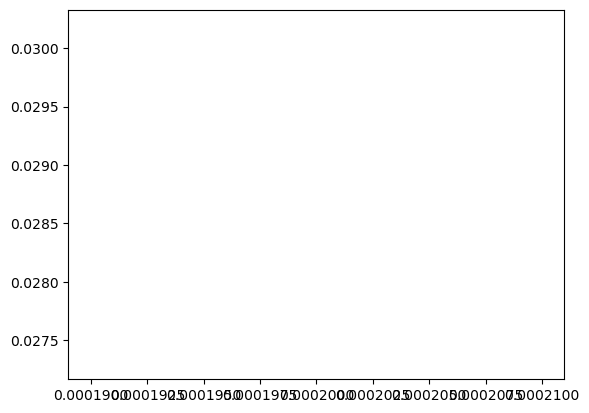

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3a508072b0>

In [31]:
plot(Displacement,Load*1e-3)

In [32]:
cd("../LD-Data_Mode1_Spectral")

In [33]:
using DelimitedFiles
Disp = writedlm( "DispDataMode1_Spectral_N0.5_lb_0.05.csv",  Displacement, ',')
Force = writedlm("LoadDataMode1_Spectral_N0.5_lb_0.05.csv",  Load, ',')